<a href="https://colab.research.google.com/github/sahar7888/NLP_LLM_Projects/blob/main/Sentiment_Analysis_Using_OHE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#%% packages
import pandas as pd
import numpy as np

from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
##Read Data
df = pd.read_csv('Tweets.csv').dropna()
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [ ]:
# %% get class values based on categories
cat_id = {'neutral':0,
          'positive':1,
          'negative':2}



In [ ]:
df['class'] = df['sentiment'].map(cat_id)
df.head()

,textID,text,selected_text,sentiment,class
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,2
2,088c60f138,my boss is bullying me...,bullying me,negative,2
3,9642c003ef,what interview! leave me alone,leave me alone,negative,2
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,2


In [ ]:
#%% Hyperparameters
BATCH_SIZE = 512
NUM_EPOCHS = 80

In [ ]:
X =df['text'].values
y =df['class'].values# converting it to a numpy array

#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state=123)
print(f"X train: {X_train.shape}, y train: {y_train.shape}\nX test: {X_test.shape}, y test: {y_test.shape}")

X train: (13740,), y train: (13740,)
X test: (13740,), y test: (13740,)


In [ ]:
#One-HoT-Encoding
one_hot = CountVectorizer()
X_train_onehot = one_hot.fit_transform(X_train)
X_test_onehot = one_hot.transform(X_test)

In [ ]:
X_train_onehot

<13740x17321 sparse matrix of type '<class 'numpy.int64'>'
	with 157703 stored elements in Compressed Sparse Row format>

In [ ]:
#%% Dataset Class
class SentimentData(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = torch.Tensor(X.toarray())
        self.y = torch.Tensor(y).type(torch.LongTensor)
        self.len = len(self.X)

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [ ]:
train_ds = SentimentData(X= X_train_onehot, y = y_train)
test_ds = SentimentData(X_test_onehot, y_test)

In [ ]:
# %% Dataloader
train_loader = DataLoader(dataset=train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=15000)


In [ ]:
# %% Model
class SentimentModel(nn.Module):
    def __init__(self, NUM_FEATURES, NUM_CLASSES, HIDDEN = 10):
        super().__init__()
        self.linear = nn.Linear(NUM_FEATURES, HIDDEN)
        self.linear2 = nn.Linear(HIDDEN, NUM_CLASSES)
        self.relu = nn.ReLU()
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.log_softmax(x)
        return x

In [ ]:
#%% Model, Loss and Optimizer
model = SentimentModel(NUM_FEATURES = X_train_onehot.shape[1], NUM_CLASSES = 3)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters())

In [ ]:
# %% Model Training

train_losses = []
for e in range(NUM_EPOCHS):
    curr_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred_log = model(X_batch)
        loss = criterion(y_pred_log, y_batch.long())

        curr_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_losses.append(curr_loss)
    print(f"Epoch {e}, Loss: {curr_loss}")

Epoch 0, Loss: 29.822470903396606
Epoch 1, Loss: 28.896756529808044
Epoch 2, Loss: 27.562135696411133
Epoch 3, Loss: 25.832915127277374
Epoch 4, Loss: 23.835223019123077
Epoch 5, Loss: 21.764553010463715
Epoch 6, Loss: 19.795025765895844
Epoch 7, Loss: 18.03649640083313
Epoch 8, Loss: 16.51050513982773
Epoch 9, Loss: 15.205671608448029
Epoch 10, Loss: 14.082993686199188
Epoch 11, Loss: 13.101132243871689
Epoch 12, Loss: 12.239447325468063
Epoch 13, Loss: 11.486102193593979
Epoch 14, Loss: 10.819884777069092
Epoch 15, Loss: 10.215681791305542
Epoch 16, Loss: 9.689737051725388
Epoch 17, Loss: 9.190250843763351
Epoch 18, Loss: 8.735344618558884
Epoch 19, Loss: 8.324780911207199
Epoch 20, Loss: 7.9463445246219635
Epoch 21, Loss: 7.598044991493225
Epoch 22, Loss: 7.272804841399193
Epoch 23, Loss: 6.975034907460213
Epoch 24, Loss: 6.682419940829277
Epoch 25, Loss: 6.424050524830818
Epoch 26, Loss: 6.170174241065979
Epoch 27, Loss: 5.936844244599342
Epoch 28, Loss: 5.725613221526146
Epoch 29,

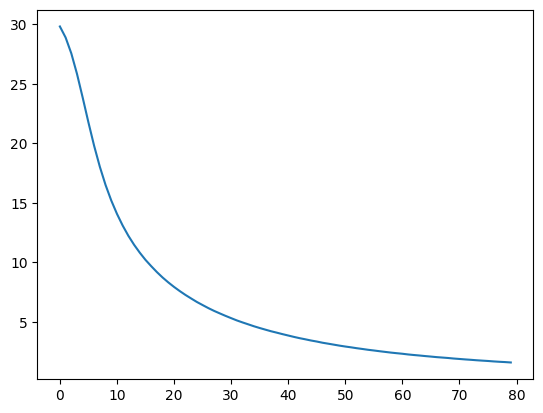

In [ ]:
# %%
sns.lineplot(x=list(range(len(train_losses))), y= train_losses)
plt.show()
# %% Model Evaluation
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_test_pred_log = model(X_batch)
        y_test_pred = torch.argmax(y_test_pred_log, dim = 1)

In [ ]:
y_test_pred_np = y_test_pred.squeeze().cpu().numpy()


Naive Classifier: 41.0 %


<Axes: >

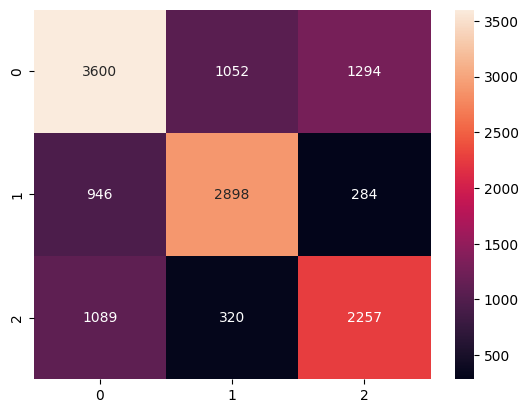

In [ ]:
acc = accuracy_score(y_pred=y_test_pred_np, y_true = y_test)
f"The accuracy of the model is {np.round(acc, 3)*100}%."
# %%
most_common_cnt = Counter(y_test).most_common()[0][1]
print(f"Naive Classifier: {np.round(most_common_cnt / len(y_test) * 100, 1)} %")
# %% Confusion Matrix
sns.heatmap(confusion_matrix(y_test_pred_np, y_test), annot=True, fmt=".0f")
# %%